## DSCI 100 Group Project: PlaiCraft Server Usage Prediction

In [1]:
# imports
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Introduction:

### Relevant Background Information:
- Work in Progress...
  
### Investigative Questions: Will be using players.csv exclusively
- Broad: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
- Specific: To what extent does player experience predict played_hours, and does that vary with age?
- How the data will help address this question:
    - We can look at the effects of using only age or experience as a predictor for played_hours, then look at how that differs from using both as predictors simultaneously. Intuitively speaking, the more experience you have, the less you need to play (until you reach a competitive threshold). The less experience you have, the more you need to play. And vice versa. Finally, age determines how much time you can dedicate to Minecraft.
- Data wrangling plans:
    - In terms of wrangling, players.csv looks generally. All the players' information is contained within a row, each cell measures one thing, and each column represents one distinct variable. That being said, the age variable contains 2 NAs, so imputation will be required, and for our regression model, encoding of the categorical variables will be needed.
      
### Data Description: players.csv
- Number of observations: 196
- Summary Statistics:
    - played_hours:
        - Min: 0.00
        - Median: 0.10
        - Mean: 5.85
        - Max: 223.10
    - Age:
        - Min: 9.00
        - Median: 19.00
        - Mean: 21.14
        - Max: 58.00
    - subscribe:
        - FALSE: 52
        - TRUE: 144
- Number of variables: 7
    - experience: Categorical/Ordinal
        - How much experience a player has playing Minecraft
    - subscribe: Categorical/Binary 
        - Whether or not a player is subscribed to a game-related newsletter
    - hashedEmail: Categorical
        - A player's email, hashed/encrypted for privacy
    - played_hours: Numerical
        - How many hours a player played on the PlaiCraft server
    - name: Categorical
        - A player's name
    - gender: Categorical
        - A player's gender
    - Age: Numerical
        - The age of a player
- Issues in the data:
    - Age variable contains 2 NAs, will require imputation
    - Imbalanced, and a poor spread of data (e.g. a lot of players have played_hours = 0)
    - Very small sample size, so results may be skewed, especially with models that are easily influenced by extreme values
- Irrelevant variables:
    - name, hashedEmail
        - This is arbitrary and does not predict how much data one might contribute

In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/Andrewhli06/dsci100-project/refs/heads/main/players.csv")
summary(player_data)
head(player_data)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## Methods and Results:

### EDA:

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


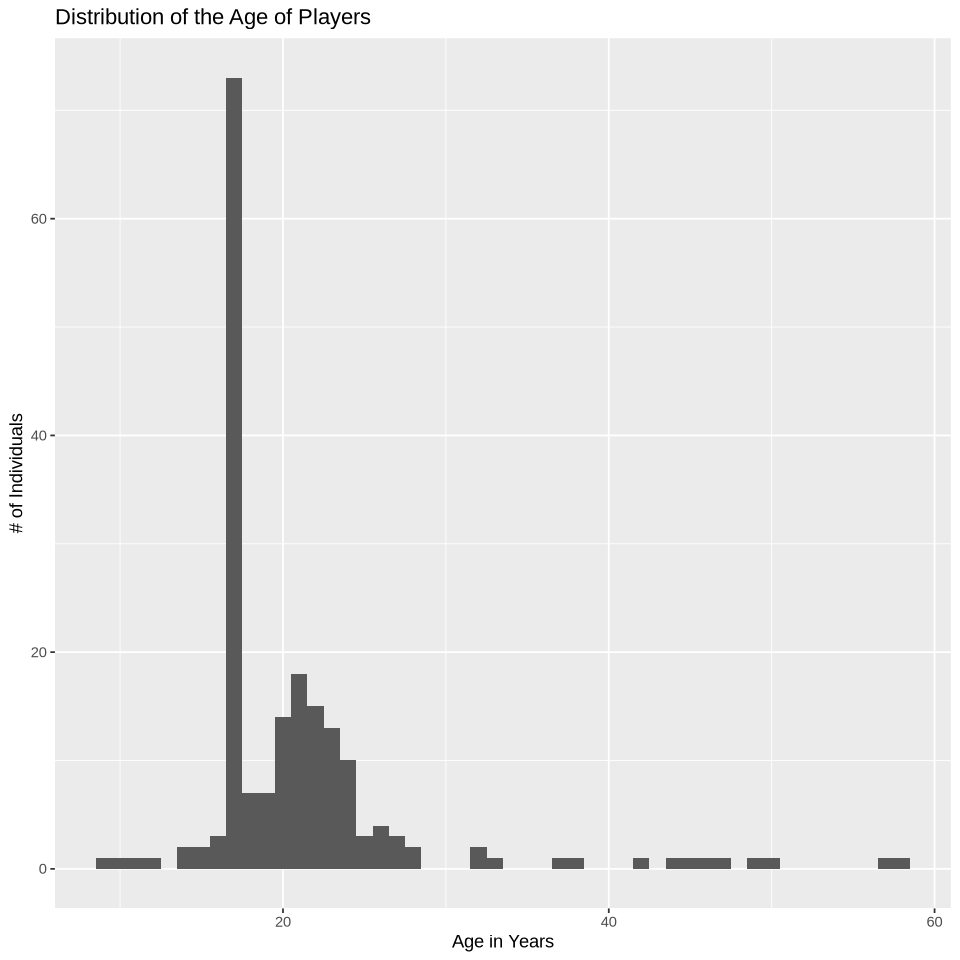

In [10]:
options(repr.plot.width = 8, repr.plot.height = 8)
age_hist <- player_data |>
            ggplot(aes(x = Age)) +
            geom_histogram(binwidth = 1) +
            labs(title = "Distribution of the Age of Players",
                 x = "Age in Years",
                 y = "# of Individuals")
age_hist

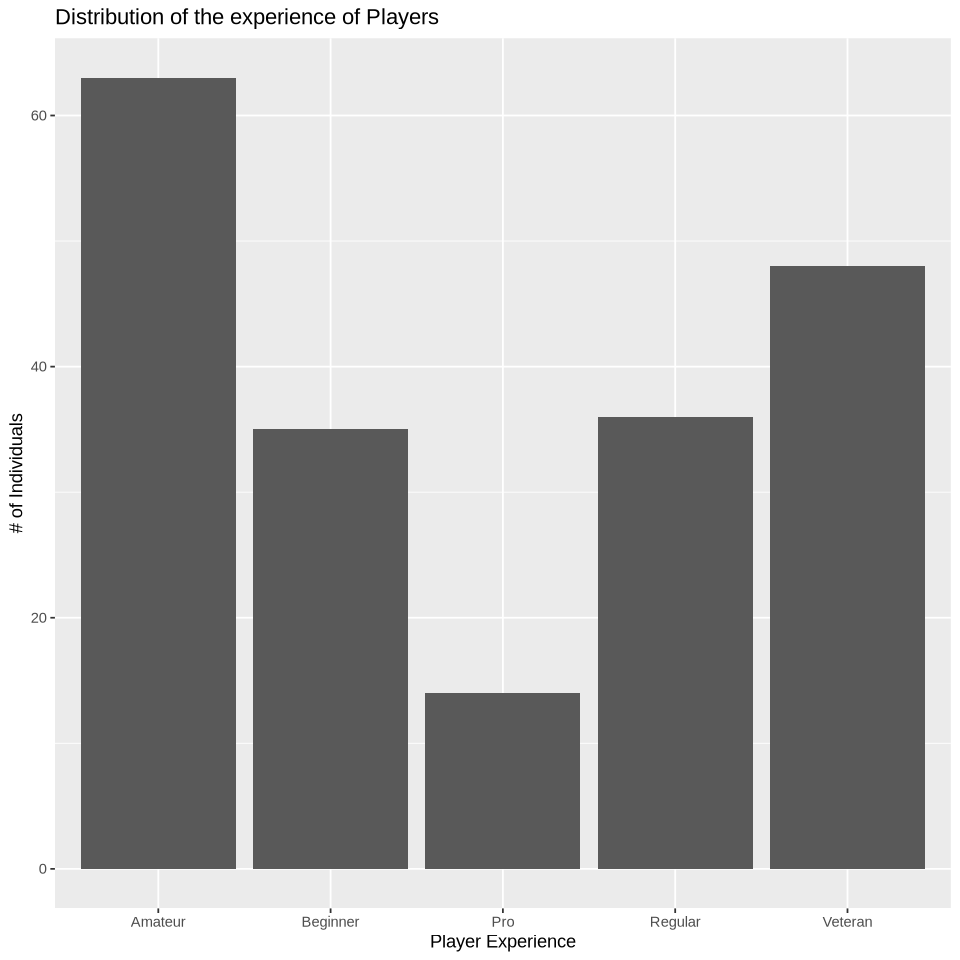

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8)
experience_bar <- player_data |>
            ggplot(aes(x = experience)) +
            geom_bar() +
            labs(title = "Distribution of the experience of Players",
                 x = "Player Experience",
                 y = "# of Individuals")
experience_bar

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


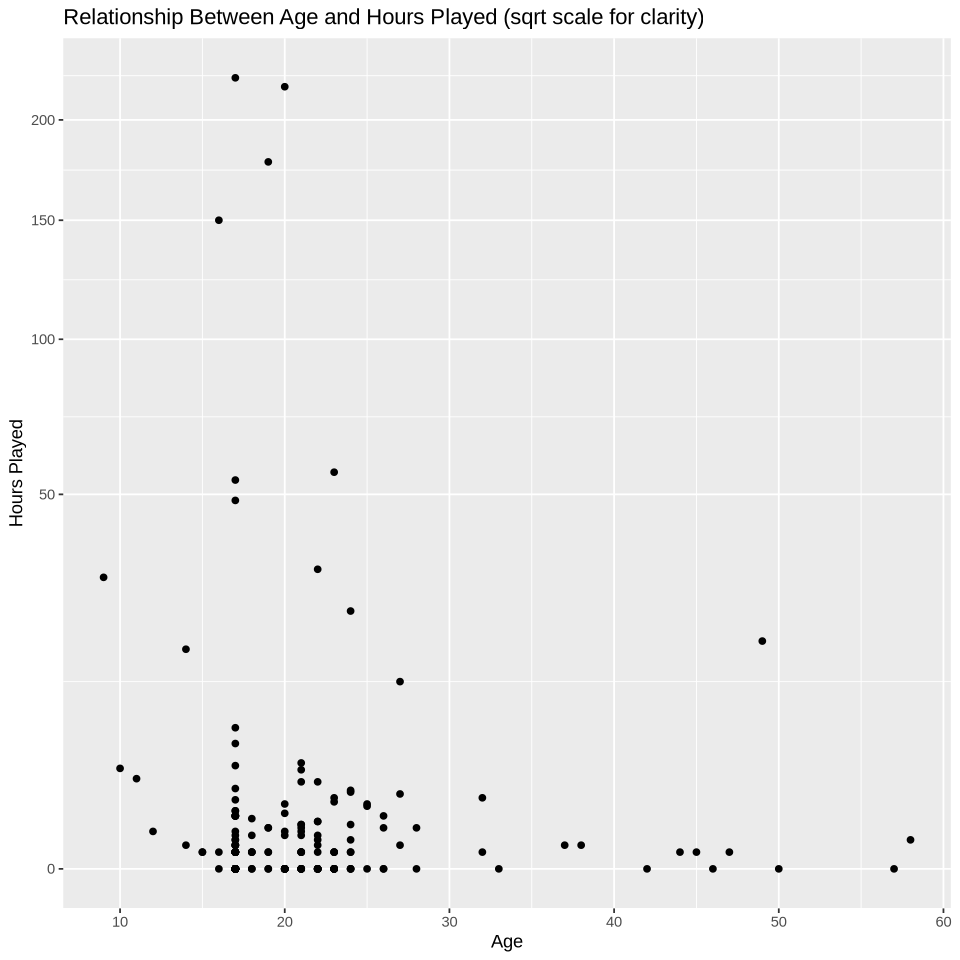

In [3]:
options(repr.plot.width = 8, repr.plot.height = 8)
age_plot <- player_data |>
            ggplot(aes(x = Age, y = played_hours)) +
            geom_point() +
            scale_y_sqrt() + # using sqrt scale so that the small values are more visible
            labs(title = "Relationship Between Age and Hours Played (sqrt scale for clarity)",
                 x = "Age",
                 y = "Hours Played")
age_plot

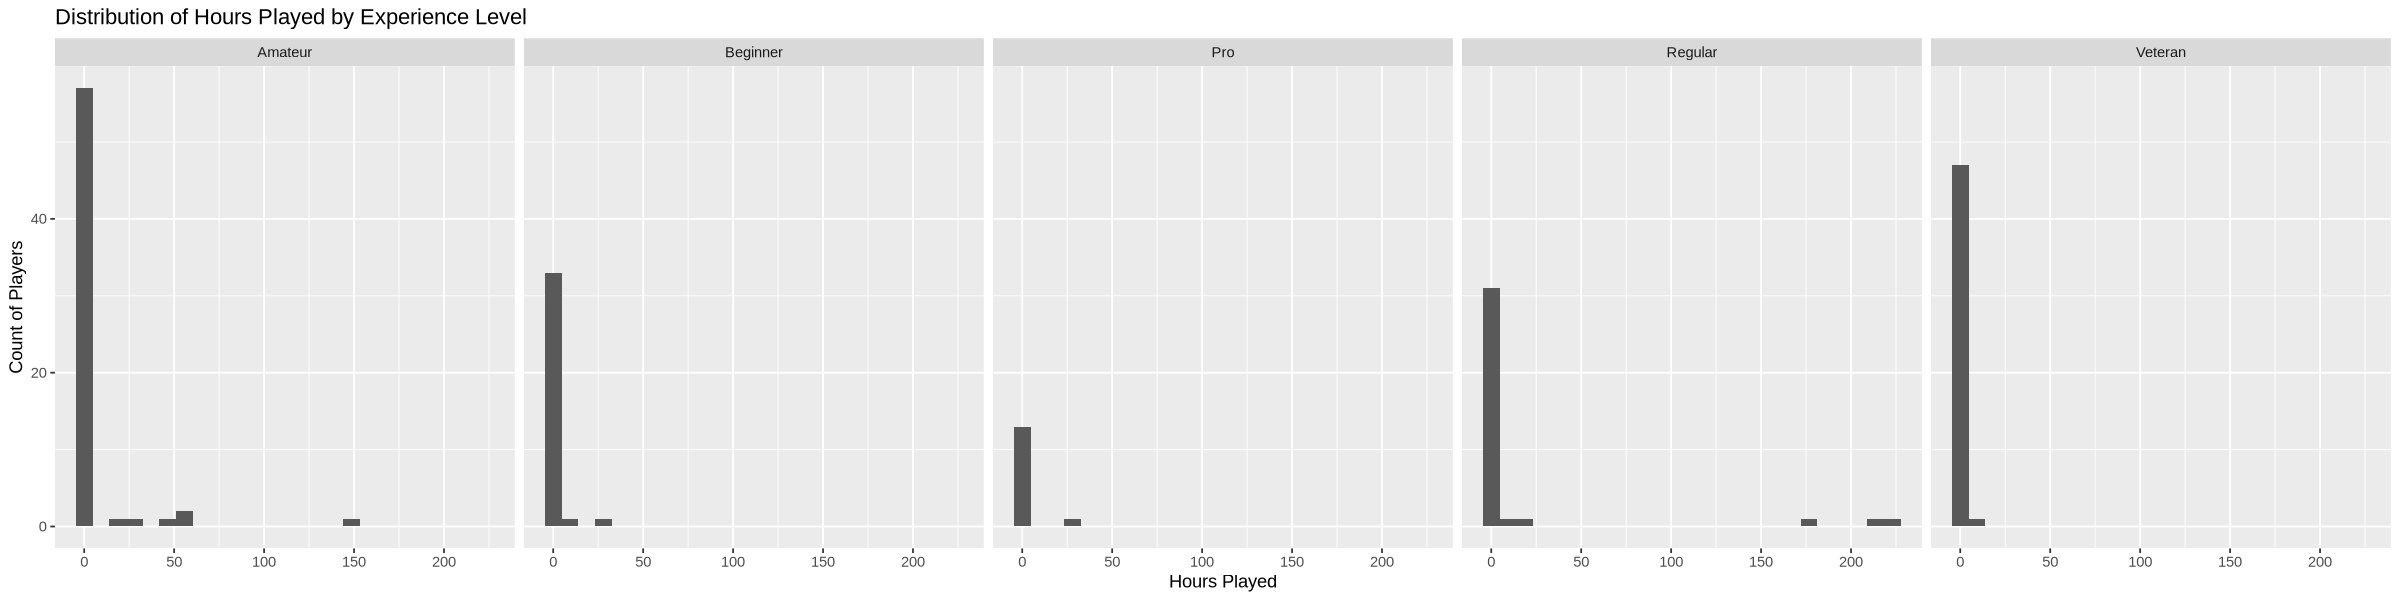

In [5]:
options(repr.plot.width = 20, repr.plot.height = 5)
exp_plot <- player_data |>
            ggplot(aes(x=played_hours)) + 
            geom_histogram(bins = 25) +
            facet_wrap(~ experience, nrow = 1) +
            labs(title = "Distribution of Hours Played by Experience Level",
                 x = "Hours Played",
                 y = "Count of Players")
exp_plot

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


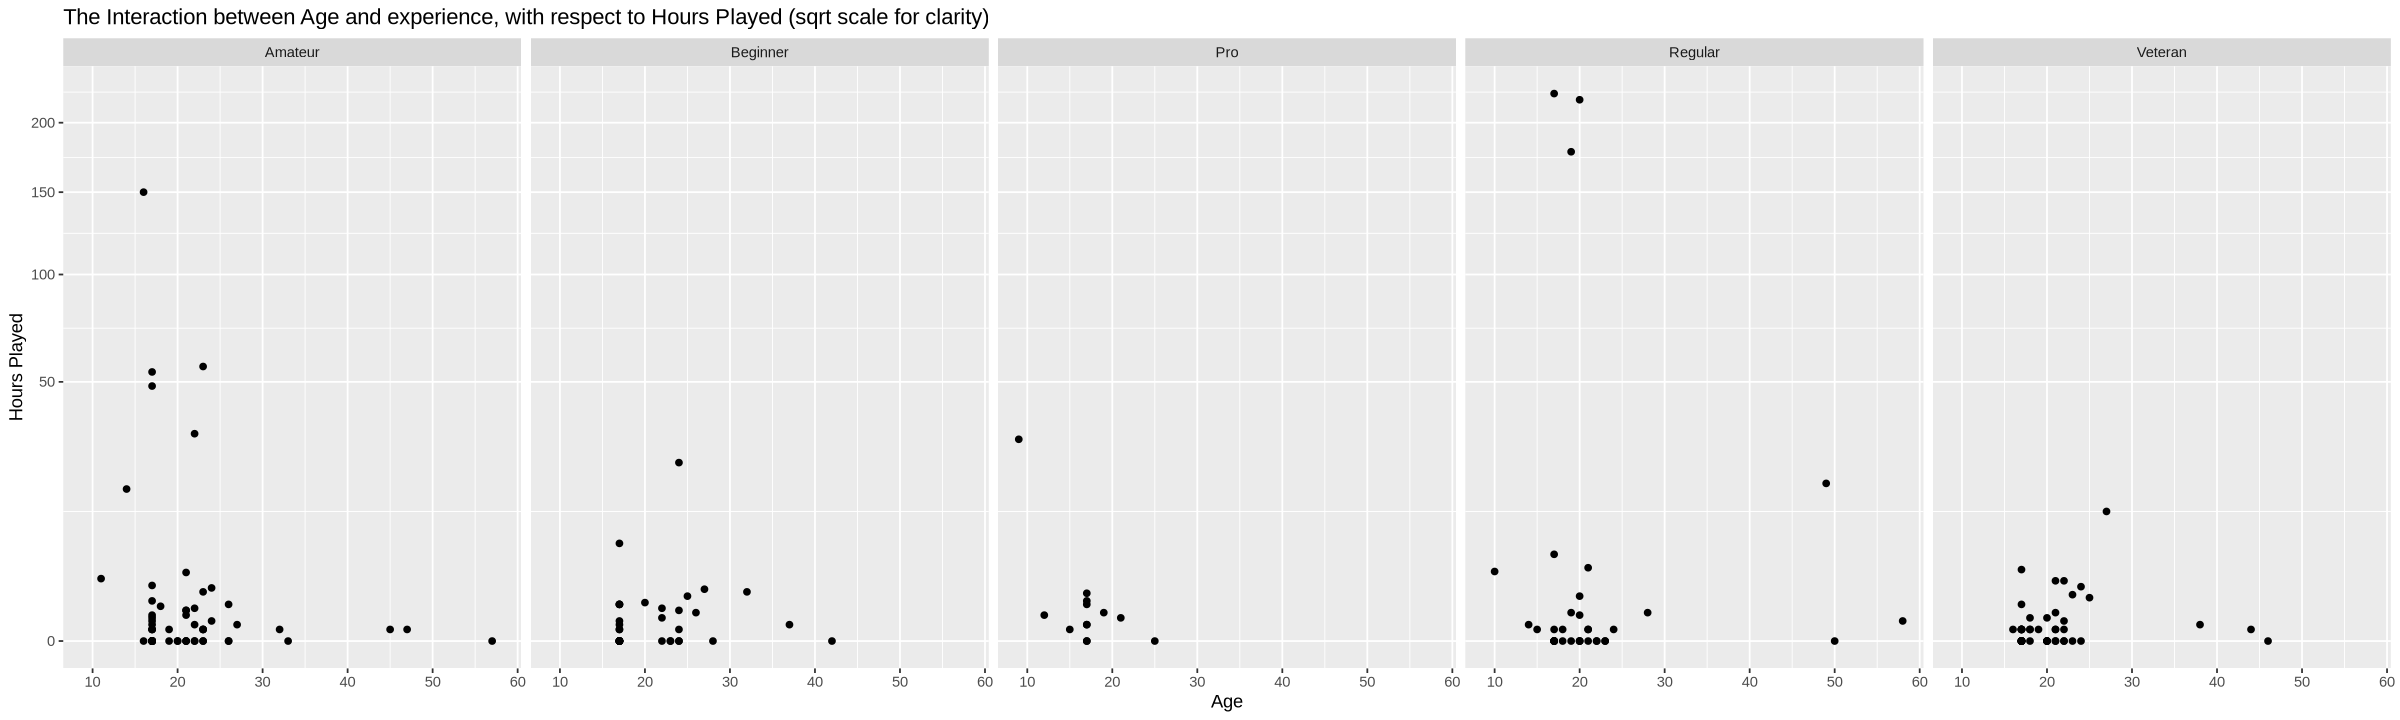

In [8]:
options(repr.plot.width = 20, repr.plot.height = 6)
interaction_plot <- player_data |>
                    ggplot(aes(x = Age, y = played_hours)) +
                    geom_point() +
                    scale_y_sqrt() + # using sqrt scale so that the small values are more visible
                    facet_wrap(~ experience, nrow = 1) +
                    labs(title = "The Interaction between Age and experience, with respect to Hours Played (sqrt scale for clarity)",
                         x = "Age",
                         y = "Hours Played")
interaction_plot

## Discussion:

### Findings:
- Work in Progress...

### Expectations vs. Reality:
- Work in Progress...

### Impact of our Findings:
- Work in Progress...

### Future Questions:
- Work in Progress...

## References (Optional)